In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

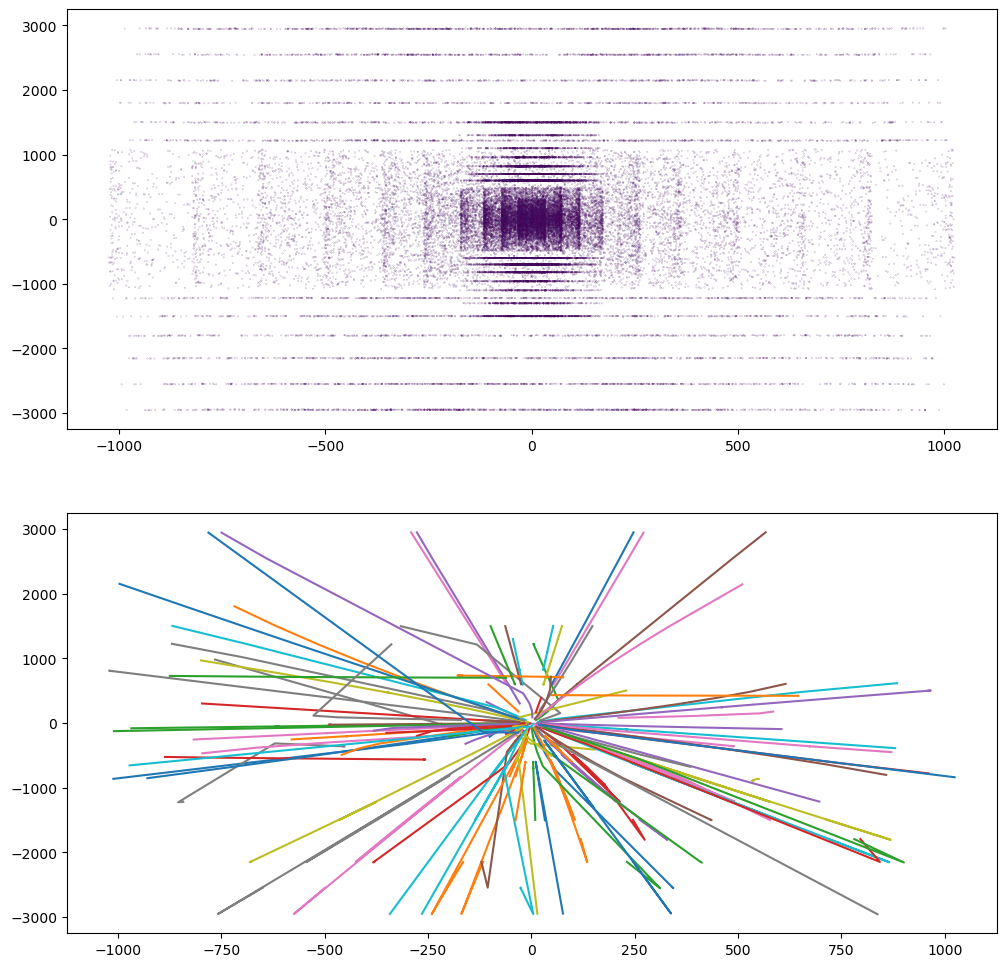

In [37]:
# Load some example data
df = pd.read_csv("Example-Data/event000001000-truth.csv")
df = df.query("weight > 0.000007")
df = df.sort_values("hit_id")
df_grouped = df.groupby("particle_id")

# Visualise the example data in 2D
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
ax1.scatter(df["tx"], df["tz"], s=0.01, c=df["weight"])
i = 0
for name, group in df_grouped:
    ax2.plot(group["tx"], group["tz"])
    if i > 100:
        break
    i += 1

Now we want to be able to visualise this all at once in 3D. Using SSV (Shaders for Scientific Visualisation), we could do so.  
We would be able to define a simple GLSL shader making use of simple library functions to visualise our data interactively in the notebook.

```py
import pyssv as ssv

fig = ssv.figure(size=(1280, 720))
# The API for this isn't finalised and I have a few ideas:
#   - Key-word arguments for different shader stages, including pre-processed shader stages
shader = fig.shader(vertex=vert, fragment=frag)  # A basic fragment shader
shader = fig.shader(pointcloud=pcloud)  # A point cloud rendering shader, when this kwarg is set the vertex and fragment shader are generated automatically, and the pointcloud function is run as a compute shader before rendering
shader = fig.shader(sdf=sdf)  # A signed distance field rendering shader, when this kwarg is set the vertex and fragment shader are generated automatically, the sdf function is evaluated at every step of the raymarching
shader = fig.shader(compute=compute1)  # Just an idea
#   - A single shader source string which can include custom preprocessor directives (#pragma) to control code generation
shader = fig.shader(full_shader)
#   - A reference to a named shader cell in the notebook
shader = fig.shader("notebook-shader-1")

# Set a constant buffer in the shader
shader["point_data"] = np.random.uniform(-1.00, 1.00, (n, 4))

# Triggers the generation of the WebGL (or compilation of the OpenGL) code
fig.run()

```

```py
# Shader examples
vert = """

"""

frag = """

"""

pcloud = """

"""
```

|  
|  
|  
|  
|  
|  
|  
|  
|  
### Below this point are the hacks used to make this demo appear functional

In [54]:
# PyThreeJS is an interesting library to look at for this, sadly though, it doesn't work out of the box with PyCharm
# https://pythreejs.readthedocs.io/en/stable/examples/ThickLines.html

In [55]:
class MockSSV:
    def __init__(self):
        self.shader_source = None
        self.size = (640, 480)
        self.buffers = {}
    
    def __setitem__(self, key, value):
        self.buffers[key] = value
        
    def __getitem__(self, key):
        return self.buffers[key]
    
    def figure(self, size=None):
        if size:
            self.size = size
            
        return self  # For this demonstration we don't need a separate class for the figure
    
    def shader(self, source):
        self.shader_source = source
        return self  # For this demonstration we don't need a separate class for the shader
    
    def run(self):
        
        return self
    
    def _gen_buffer_str(self):
        ret = "\n".join([f"lines.push([{line}]);" for line in self.buffers["lines"]])
        print(ret)
        return ret
    
    def _repr_html_(self) -> str:
        # This is what does the magic in this demo
        # This template is derived from: https://github.com/mrdoob/three.js/blob/master/examples/webgl_lines_fat.html
        return f"""
<div class="MockSSV">
<!-- This code is modified from: https://github.com/mrdoob/three.js/blob/master/examples/webgl_lines_fat.html -->
<div id="container"></div>
<div>Test</div>

<!-- Import maps polyfill -->
<script async src="https://unpkg.com/es-module-shims@1.8.0/dist/es-module-shims.js"></script>

<script type="importmap">
  {{
    "imports": {{
      "three": "https://unpkg.com/three@latest/build/three.module.js",
      "three/addons/": "https://unpkg.com/three@latest/examples/jsm/"
    }}
  }}
</script>

<script type="module">
  import * as THREE from 'three';
  import {{ OrbitControls }} from 'three/addons/controls/OrbitControls.js';
  import {{ Line2 }} from 'three/addons/lines/Line2.js';
  import {{ LineMaterial }} from 'three/addons/lines/LineMaterial.js';
  import {{ LineGeometry }} from 'three/addons/lines/LineGeometry.js';
  import * as GeometryUtils from 'three/addons/utils/GeometryUtils.js';
  let line, renderer, scene, camera, controls;
  let line1;
  let matLine, matLineBasic, matLineDashed;
  
  init();
  animate();

  function init() {{
    renderer = new THREE.WebGLRenderer({{
      antialias: true
    }});
    renderer.setPixelRatio(window.devicePixelRatio);
    renderer.setClearColor(0x000000, 0.0);
    renderer.setSize(window.innerWidth, window.innerHeight);
    document.body.appendChild(renderer.domElement);
    scene = new THREE.Scene();
    
    camera = new THREE.PerspectiveCamera(40, window.innerWidth / window.innerHeight, 1, 1000);
    camera.position.set(-40, 0, 60);
    
    controls = new OrbitControls(camera, renderer.domElement);
    controls.minDistance = 10;
    controls.maxDistance = 500;
    
    // Position and THREE.Color Data
    const positions = [];
    const colors = [];
    const lines = [];
    const color = new THREE.Color();
    {self._gen_buffer_str()}
    
    for(let i = 0; i < lines.length; i++) {{
      color.setHSL(i/lines.length, 1.0, 0.5, THREE.SRGBColorSpace );
      createLine(lines[i], color, scene);
    }}
    
    window.addEventListener('resize', onWindowResize);
    onWindowResize();
  }}
  
  function createLine(points, color, scene) {{
    const geometry = new LineGeometry();
    const positions = [];
    const colors = [];
    for ( let i = 0; i < points.length; i ++ ) {{
      positions.push( points[i][0], points[i][1], points[i][2]);
      colors.push( color.r, color.g, color.b );
      console.info(positions[i]);
    }}
    console.info(positions);
    geometry.setPositions(positions);
    geometry.setColors(colors);
    matLine = new LineMaterial({{
      color: 0xffffff,
      linewidth: .5, // in world units with size attenuation, pixels otherwise
      vertexColors: true,
      //resolution:  // to be set by renderer, eventually
      dashed: false,
      alphaToCoverage: false,
      worldUnits: true
    }});
    line = new Line2(geometry, matLine);
    line.computeLineDistances();
    line.scale.set(1, 1, 1);
    scene.add(line);
  }}

  function onWindowResize() {{
    camera.aspect = window.innerWidth / window.innerHeight;
    camera.updateProjectionMatrix();
    renderer.setSize(window.innerWidth, window.innerHeight);
  }}

  function animate() {{
    requestAnimationFrame(animate);
    // main scene
    renderer.setClearColor(0x000000, 0);
    renderer.setViewport(0, 0, window.innerWidth, window.innerHeight);
    // renderer will set this eventually
    matLine.resolution.set(window.innerWidth, window.innerHeight); // resolution of the viewport
    renderer.render(scene, camera);
  }}
</script>
</div>
"""

In [57]:
ssv = MockSSV()
ssv["lines"] = [[[0.0,0.0,0.0], [0.0,1.0,0.0], [0.0,1.0,1.0]], [[0.0,0.0,0.0], [0.0,-1.0,0.0], [0.0,-1.0,-2.0]]]
ssv

lines.push([[[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 1.0]]]);
lines.push([[[0.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, -1.0, -2.0]]]);
